<a href="https://colab.research.google.com/github/GIRIME262/transferencia-de-estilo-neuronal/blob/main/Trabajo_Final_CNN_Pablo_Germ%C3%A1n_Giri_Style_Transfer_N%C2%B08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Style Transfer

<img src="https://i0.wp.com/chelseatroy.com/wp-content/uploads/2018/12/neural_style_transfer.png?resize=768%2C311&ssl=1">




In [ ]:
# Imagen para estilo

!wget https://upload.wikimedia.org/wikipedia/commons/5/52/La_noche_estrellada1.jpg

# Imagen para contenido
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/f/f4/Neckarfront_T%C3%BCbingen_Mai_2017.jpg/775px-Neckarfront_T%C3%BCbingen_Mai_2017.jpg

# Creamos el directorio para los archivos de salida
!mkdir /content/output-1
!mkdir /content/output-2
!mkdir /content/output-3
!mkdir /content/output-4




--2021-01-12 20:18:20--  https://upload.wikimedia.org/wikipedia/commons/5/52/La_noche_estrellada1.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 223725 (218K) [image/jpeg]
Saving to: ‘La_noche_estrellada1.jpg’

La_noche_estrellada 100%[===================>] 218.48K  --.-KB/s    in 0.007s  

2021-01-12 20:18:20 (29.2 MB/s) - ‘La_noche_estrellada1.jpg’ saved [223725/223725]

--2021-01-12 20:18:20--  https://upload.wikimedia.org/wikipedia/commons/thumb/f/f4/Neckarfront_T%C3%BCbingen_Mai_2017.jpg/775px-Neckarfront_T%C3%BCbingen_Mai_2017.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 153015 (149K) [ima

In [ ]:
%tensorflow_version 1.x
from keras.preprocessing.image import load_img, save_img, img_to_array
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import time
import argparse
import matplotlib.pyplot as plt
from keras.applications import vgg19
from keras import backend as K
from pathlib import Path
import tensorflow
print(tensorflow.__version__)

1.15.2


In [ ]:
base_image_path = Path("/content/775px-Neckarfront_Tübingen_Mai_2017.jpg")
style_reference_image_path = Path("/content/La_noche_estrellada1.jpg")
result_prefix_1 = Path("/content/output-1")
result_prefix_2 = Path("/content/output-2")
result_prefix_3 = Path("/content/output-3")
result_prefix_4 = Path("/content/output-4")

In [ ]:
# Generación de imágenes N°1
content_weight = 0.025
style_weight = 0.004
total_variation_weight = 0.8

In [ ]:
#Generación de imágenes N°2
content_weight = 5.0
style_weight = 5.0
total_variation_weight = 1.0

In [ ]:
#Generación de imágenes N°3
content_weight = 0.009
style_weight = 0.0003
total_variation_weight = 0.001

In [ ]:
#Generación de imágenes N°4
content_weight = 1
style_weight = 1
total_variation_weight = 10

In [ ]:
# Definimos el tamaño de las imágenes a utilizar
width, height = load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def deprocess_image(x):
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_reference_image_path))

combination_image = K.placeholder((1, img_nrows, img_ncols, 3))

input_tensor = K.concatenate([base_image,
                              style_reference_image,
                              combination_image], axis=0)

model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet', include_top=False)

outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

def content_loss(base, combination):
    return K.sum(K.square(combination - base))

def total_variation_loss(x):
    assert K.ndim(x) == 4
    a = K.square(
        x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
    b = K.square(
        x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

# Armamos la loss total
loss = K.variable(0.0)
layer_features = outputs_dict['block5_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(base_image_features,
                                            combination_features)

feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :] 
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss = loss + (style_weight / len(feature_layers)) * sl
loss = loss + total_variation_weight * total_variation_loss(combination_image)

grads = K.gradients(loss, combination_image)

outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

f_outputs = K.function([combination_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values



In [ ]:

evaluator = Evaluator()
iterations =100
# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss
x = preprocess_image(base_image_path)

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    # save current generated image
    img = deprocess_image(x.copy())
    fname = result_prefix_1 / ('output_at_iteration_%d.png' % i)
    save_img(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))



Start of iteration 0
Current loss value: 218385890.0
Image saved as /content/output-1/output_at_iteration_0.png
Iteration 0 completed in 15s
Start of iteration 1
Current loss value: 185771780.0
Image saved as /content/output-1/output_at_iteration_1.png
Iteration 1 completed in 6s
Start of iteration 2
Current loss value: 176952600.0
Image saved as /content/output-1/output_at_iteration_2.png
Iteration 2 completed in 6s
Start of iteration 3
Current loss value: 172459230.0
Image saved as /content/output-1/output_at_iteration_3.png
Iteration 3 completed in 6s
Start of iteration 4
Current loss value: 169517280.0
Image saved as /content/output-1/output_at_iteration_4.png
Iteration 4 completed in 6s
Start of iteration 5
Current loss value: 167245780.0
Image saved as /content/output-1/output_at_iteration_5.png
Iteration 5 completed in 6s
Start of iteration 6
Current loss value: 165433970.0
Image saved as /content/output-1/output_at_iteration_6.png
Iteration 6 completed in 6s
Start of iteration 

In [ ]:
evaluator = Evaluator()
iterations =100
# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss
x = preprocess_image(base_image_path)

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    # save current generated image
    img = deprocess_image(x.copy())
    fname = result_prefix_2 / ('output_at_iteration_%d.png' % i)
    save_img(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))


Start of iteration 0
Current loss value: 16218574000.0
Image saved as /content/output-2/output_at_iteration_0.png
Iteration 0 completed in 6s
Start of iteration 1
Current loss value: 8785577000.0
Image saved as /content/output-2/output_at_iteration_1.png
Iteration 1 completed in 6s
Start of iteration 2
Current loss value: 6908156000.0
Image saved as /content/output-2/output_at_iteration_2.png
Iteration 2 completed in 6s
Start of iteration 3
Current loss value: 5990351000.0
Image saved as /content/output-2/output_at_iteration_3.png
Iteration 3 completed in 6s
Start of iteration 4
Current loss value: 5438044000.0
Image saved as /content/output-2/output_at_iteration_4.png
Iteration 4 completed in 6s
Start of iteration 5
Current loss value: 5151172600.0
Image saved as /content/output-2/output_at_iteration_5.png
Iteration 5 completed in 6s
Start of iteration 6
Current loss value: 4904365000.0
Image saved as /content/output-2/output_at_iteration_6.png
Iteration 6 completed in 6s
Start of ite

In [ ]:
evaluator = Evaluator()
iterations =100
# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss
x = preprocess_image(base_image_path)

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    # save current generated image
    img = deprocess_image(x.copy())
    fname = result_prefix_3 / ('output_at_iteration_%d.png' % i)
    save_img(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))


Start of iteration 0
Current loss value: 5073044.0
Image saved as /content/output-3/output_at_iteration_0.png
Iteration 0 completed in 6s
Start of iteration 1
Current loss value: 3598738.5
Image saved as /content/output-3/output_at_iteration_1.png
Iteration 1 completed in 6s
Start of iteration 2
Current loss value: 3121945.0
Image saved as /content/output-3/output_at_iteration_2.png
Iteration 2 completed in 6s
Start of iteration 3
Current loss value: 2892998.0
Image saved as /content/output-3/output_at_iteration_3.png
Iteration 3 completed in 6s
Start of iteration 4
Current loss value: 2755798.2
Image saved as /content/output-3/output_at_iteration_4.png
Iteration 4 completed in 6s
Start of iteration 5
Current loss value: 2653012.8
Image saved as /content/output-3/output_at_iteration_5.png
Iteration 5 completed in 6s
Start of iteration 6
Current loss value: 2582065.5
Image saved as /content/output-3/output_at_iteration_6.png
Iteration 6 completed in 6s
Start of iteration 7
Current loss 

In [ ]:
evaluator = Evaluator()
iterations =100
# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss
x = preprocess_image(base_image_path)

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    # save current generated image
    img = deprocess_image(x.copy())
    fname = result_prefix_4 / ('output_at_iteration_%d.png' % i)
    save_img(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))


Start of iteration 0
Current loss value: 14393684000.0
Image saved as /content/output-4/output_at_iteration_0.png
Iteration 0 completed in 6s
Start of iteration 1
Current loss value: 11206668000.0
Image saved as /content/output-4/output_at_iteration_1.png
Iteration 1 completed in 6s
Start of iteration 2
Current loss value: 10095591000.0
Image saved as /content/output-4/output_at_iteration_2.png
Iteration 2 completed in 6s
Start of iteration 3
Current loss value: 9453676000.0
Image saved as /content/output-4/output_at_iteration_3.png
Iteration 3 completed in 6s
Start of iteration 4
Current loss value: 9047111000.0
Image saved as /content/output-4/output_at_iteration_4.png
Iteration 4 completed in 6s
Start of iteration 5
Current loss value: 8739568000.0
Image saved as /content/output-4/output_at_iteration_5.png
Iteration 5 completed in 6s
Start of iteration 6
Current loss value: 8498992600.0
Image saved as /content/output-4/output_at_iteration_6.png
Iteration 6 completed in 6s
Start of i

# 8) Generar imágenes para distintas combinaciones de pesos de las losses. Explicar las diferencias. (Adjuntar las imágenes generadas como archivos separados.)


Se realizo cuatros imágenes con distintos valores weight, lo que resulto que, con valores de pesos altos, la (loss) fue muy alto. 

Con respeto a los resultados de las imágenes, si uno varía los valores de content_weight y style_weight, se obtiene distintos resultados dependiendo el que tenga el valor mas alto de los dos, tendrá más estilo o contenido. Ejemplo a mayor valor de style_weight, tendrá más textura. 



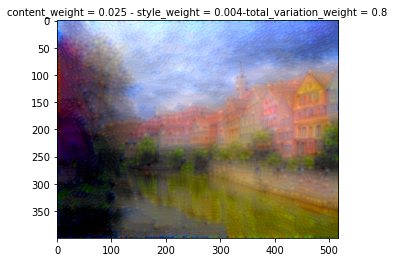

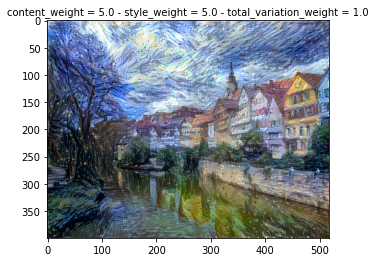

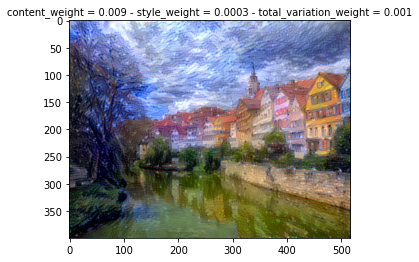

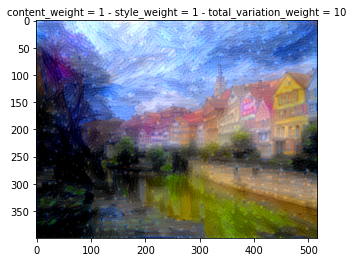

In [ ]:

plt.figure()

plt.title("content_weight = 0.025 - style_weight = 0.004-total_variation_weight = 0.8",fontsize=10)
img2 = load_img('/content/output-1/output_at_iteration_99.png')
plt.imshow(img2)

plt.figure()

plt.title("content_weight = 5.0 - style_weight = 5.0 - total_variation_weight = 1.0",fontsize=10)
img2 = load_img('/content/output-2/output_at_iteration_99.png')
plt.imshow(img2)

plt.figure()

plt.title("content_weight = 0.009 - style_weight = 0.0003 - total_variation_weight = 0.001",fontsize=10)
img2 = load_img('/content/output-3/output_at_iteration_99.png')
plt.imshow(img2)

plt.figure()

plt.title("content_weight = 1 - style_weight = 1 - total_variation_weight = 10",fontsize=10)
img2 = load_img('/content/output-4/output_at_iteration_99.png')
plt.imshow(img2)